# Exploring precision and recall

The goal of this second notebook is to understand precision-recall in the context of classifiers.

 * Use Amazon review data in its entirety.
 * Train a logistic regression model.
 * Explore various evaluation metrics: accuracy, confusion matrix, precision, recall.
 * Explore how various metrics can be combined to produce a cost of making an error.
 * Explore precision and recall curves.


### 1. Load amazon review dataset

### 2. Extract word counts and sentiments

As in the first assignment of this course, we compute the word counts for individual words and extract positive and negative sentiments from ratings. To summarize, we perform the following:

1. Remove punctuation.
2. Remove reviews with "neutral" sentiment (rating 3).
3. Set reviews with rating 4 or more to be positive and those with 2 or less to be negative.

### 3. Split data into training and test sets

### 4. Build the word count vector for each review
We will now compute the word count for each word that appears in the reviews. A vector consisting of word counts is often referred to as bag-of-word features. Since most words occur in only a few reviews, word count vectors are sparse. For this reason, scikit-learn and many other tools use sparse matrices to store a collection of word count vectors. Refer to appropriate manuals to produce sparse word count vectors. General steps for extracting word count vectors are as follows: Learn a vocabulary (set of all words) from the training data. Only the words that show up in the training data will be considered for feature extraction. Compute the occurrences of the words in each review and collect them into a row vector. Build a sparse matrix where each row is the word count vector for the corresponding review. Call this matrix train_matrix. Using the same mapping between words and columns, convert the test data into a sparse matrix test_matrix.

In [1]:
import pandas as pd
import numpy as np
import string
import json
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import datasets, linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def readjson(path):
    try:
        with open(path,'r') as f:
            data = json.load(f)
        return data
    except FileNotFoundError:
        raise FileNotFoundError( "Please check the path and try agaian!!!")
        
products = pd.read_csv('amazon_baby.csv')
products = products.fillna({'review':''})  # fill in N/A's in the review column
products['review_clean'] = products['review'].apply(lambda x: remove_punctuation(x))
products = products[products['rating'] != 3].copy(deep=True)
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)
train_list = readjson(path='module-9-assignment-train-idx.json')
test_list = readjson(path='module-9-assignment-test-idx.json')

train_data = products.iloc[train_list].copy(deep=True)
test_data = products.iloc[test_list].copy(deep=True)

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
# Use this token pattern to keep single-letter words
# First, learn vocabulary from the training data and assign columns to words
# Then convert the training data into a sparse matrix
train_matrix = vectorizer.fit_transform(train_data['review_clean'])
# Second, convert the test data into a sparse matrix, using the same word-column mapping
test_matrix = vectorizer.transform(test_data['review_clean'])

### Train a sentiment classifier with logistic regression
We will now use logistic regression to create a sentiment classifier on the training data. Learn a logistic regression classifier using the training data. If you are using scikit-learn, you should create an instance of the LogisticRegression class and then call the method fit() to train the classifier. This model should use the sparse word count matrix (train_matrix) as features and the column sentiment of train_data as the target. Use the default values for other parameters. Call this model sentiment_model.

In [2]:
model = LogisticRegression()
model.fit(train_matrix, train_data['sentiment'])

/anaconda3/envs/AI-ML/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/AI-ML/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### Model Evaluation
### Accuracy

In [3]:
accuracy = accuracy_score(y_true=test_data['sentiment'], y_pred=model.predict(test_matrix))
print ("Test Accuracy: %s" % accuracy)

Test Accuracy: 0.9323854091672666


### Baseline: Majority class prediction
Recall from an earlier assignment that we used the majority class classifier as a baseline (i.e reference) model for a point of comparison with a more sophisticated classifier. The majority classifier model predicts the majority class for all data points. Typically, a good model should beat the majority class classifier. Since the majority class in this dataset is the positive class (i.e., there are more positive than negative reviews), the accuracy of the majority class classifier is simply the fraction of positive reviews in the test set:

In [4]:
baseline = float(len(test_data[test_data['sentiment'] == 1]))/len(test_data)
print ("Baseline accuracy (majority class classifier): %s" % baseline)

Baseline accuracy (majority class classifier): 0.8427825773938085


**Quiz question: Using accuracy as the evaluation metric, was our logistic regression model better than the baseline (majority class classifier)?**

### Confusion Matrix

The accuracy, while convenient, does not tell the whole story. For a fuller picture, we turn to the **confusion matrix**. In the case of binary classification, the confusion matrix is a 2-by-2 matrix laying out correct and incorrect predictions made in each label as follows:
```
              +---------------------------------------------+
              |                Predicted label              |
              +----------------------+----------------------+
              |          (+1)        |         (-1)         |
+-------+-----+----------------------+----------------------+
| True  |(+1) | # of true positives  | # of false negatives |
| label +-----+----------------------+----------------------+
|       |(-1) | # of false positives | # of true negatives  |
+-------+-----+----------------------+----------------------+
```
To print out the confusion matrix for a classifier, use `metric='confusion_matrix'`:

In [5]:
cmat = confusion_matrix(y_true=test_data['sentiment'],
                        y_pred=model.predict(test_matrix),
                        labels=model.classes_)    # use the same order of class as the LR model.
print (' target_label | predicted_label | count ')
print ('--------------+-----------------+-------')
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print ('{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j]))

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  3789
     -1       |        1        |  1452
      1       |       -1        |   802
      1       |        1        | 27293


**Quiz Question: How many predicted values in the test set are false positives?**

### Computing the cost of mistakes
Put yourself in the shoes of a manufacturer that sells a baby product on Amazon.com and you want to monitor your product's reviews in order to respond to complaints. Even a few negative reviews may generate a lot of bad publicity about the product. So you don't want to miss any reviews with negative sentiments --- you'd rather put up with false alarms about potentially negative reviews instead of missing negative reviews entirely. In other words, false positives cost more than false negatives. (It may be the other way around for other scenarios, but let's stick with the manufacturer's scenario for now.) Suppose you know the costs involved in each kind of mistake: $100 for each false positive. $1 for each false negative. Correctly classified reviews incur no cost. Quiz Question: Given the stipulation, what is the cost associated with the logistic regression classifier's performance on the test set?

In [6]:
cost = 100*1453+1*804
cost

146104

## Precision and Recall

You may not have exact dollar amounts for each kind of mistake. Instead, you may simply prefer to reduce the percentage of false positives to be less than, say, 3.5% of all positive predictions. This is where **precision** comes in:

$$
[\text{precision}] = \frac{[\text{# positive data points with positive predicitions}]}{\text{[# all data points with positive predictions]}} = \frac{[\text{# true positives}]}{[\text{# true positives}] + [\text{# false positives}]}
$$

So to keep the percentage of false positives below 3.5% of positive predictions, we must raise the precision to 96.5% or higher. 

**First**, let us compute the precision of the logistic regression classifier on the **test_data**.

In [7]:
precision = precision_score(y_true=test_data['sentiment'], 
                            y_pred=model.predict(test_matrix))
print ("Precision on test data: %s" % precision)

Precision on test data: 0.9494868672812663


**Quiz Question: Out of all reviews in the test set that are predicted to be positive, what fraction of them are false positives? (Round to the second decimal place e.g. 0.25)**

In [8]:
1-precision

0.0505131327187337

**Quiz Question:** Based on what we learned in lecture, if we wanted to reduce this fraction of false positives to be below 3.5%, we would: (see the quiz)

A complementary metric is **recall**, which measures the ratio between the number of true positives and that of (ground-truth) positive reviews:

$$
[\text{recall}] = \frac{[\text{# positive data points with positive predicitions}]}{\text{[# all positive data points]}} = \frac{[\text{# true positives}]}{[\text{# true positives}] + [\text{# false negatives}]}
$$

Let us compute the recall on the **test_data**.

In [9]:
recall = recall_score(y_true=test_data['sentiment'],
                      y_pred=model.predict(test_matrix))
print ("Recall on test data: %s" % recall)

Recall on test data: 0.9714539953728422


**Quiz Question**: What fraction of the positive reviews in the **test_set** were correctly predicted as positive by the classifier?

**Quiz Question**: What is the recall value for a classifier that predicts **+1** for all data points in the **test_data**?

recall = predicted positive / (predicted positive + false negative )

Since we predict positive for all, there is no false negative. Our formula becomes 

- recall = predicted positive / predicted positive = 1

# Precision-recall tradeoff

In this part, we will explore the trade-off between precision and recall discussed in the lecture.  We first examine what happens when we use a different threshold value for making class predictions.  We then explore a range of threshold values and plot the associated precision-recall curve.  


## Varying the threshold

False positives are costly in our example, so we may want to be more conservative about making positive predictions. To achieve this, instead of thresholding class probabilities at 0.5, we can choose a higher threshold. 

Write a function called `apply_threshold` that accepts two things
* `probabilities` (an SArray of probability values)
* `threshold` (a float between 0 and 1).

The function should return an array, where each element is set to +1 or -1 depending whether the corresponding probability exceeds `threshold`.

In [10]:
def apply_threshold(probabilities, threshold):
    prediction = pd.Series(probabilities).apply(lambda probability: +1 if probability > threshold else -1)
    return prediction        

Using the model you trained, compute the class probability values P(y=+1|x,w) for the data points in the test_data. Then use thresholds set at 0.5 (default) and 0.9 to make predictions from these probability values.

Note. If you are using scikit-learn, make sure to use predict_proba() function, not decision_function(). Also, note that the predict_proba() function returns the probability values for both classes +1 and -1. So make sure to extract the second column, which correspond to the class +1.

In [11]:
probabilities = model.predict_proba(test_matrix)[:,1]
prediction_1 = apply_threshold(probabilities, 0.5)
prediction_2 = apply_threshold(probabilities, 0.9)

In [12]:
print ("Number of predicted positive sentiments with threshold 0.5 is: {}".format(sum(prediction_1 == 1)))

Number of predicted positive sentiments with threshold 0.5 is: 28745


In [13]:
print ("Number of predicted positive sentiments with threshold 0.9 is: {}".format(sum(prediction_2 == 1)))

Number of predicted positive sentiments with threshold 0.9 is: 25067


**Quiz Question**: What happens to the number of positive predicted reviews as the threshold increased from 0.5 to 0.9?

## Exploring the associated precision and recall as the threshold varies

By changing the probability threshold, it is possible to influence precision and recall. We can explore this as follows:

**Quiz Question (variant 1): Does the precision increase with a higher threshold?**

In [14]:
precision_1 = precision_score(y_true=test_data['sentiment'], 
                            y_pred=prediction_1)
precision_2 = precision_score(y_true = test_data['sentiment'],
                             y_pred = prediction_2)
precision_1 < precision_2

True

**Quiz Question (variant 2): Does the recall increase with a higher threshold?**

In [15]:
recall_1 = recall_score(y_true=test_data['sentiment'],
                       y_pred=prediction_1)
recall_2 = recall_score(y_true=test_data['sentiment'],
                       y_pred=prediction_2)
recall_1 < recall_2

False

### Precision-recall curve
Now, we will explore various different values of tresholds, compute the precision and recall scores, and then plot the precision-recall curve. Use 100 equally spaced values between 0.5 and 1. In Python, we run

In [16]:
threshold_values = np.linspace(0.5, 1, num=100)
print (threshold_values)

[0.5        0.50505051 0.51010101 0.51515152 0.52020202 0.52525253
 0.53030303 0.53535354 0.54040404 0.54545455 0.55050505 0.55555556
 0.56060606 0.56565657 0.57070707 0.57575758 0.58080808 0.58585859
 0.59090909 0.5959596  0.6010101  0.60606061 0.61111111 0.61616162
 0.62121212 0.62626263 0.63131313 0.63636364 0.64141414 0.64646465
 0.65151515 0.65656566 0.66161616 0.66666667 0.67171717 0.67676768
 0.68181818 0.68686869 0.69191919 0.6969697  0.7020202  0.70707071
 0.71212121 0.71717172 0.72222222 0.72727273 0.73232323 0.73737374
 0.74242424 0.74747475 0.75252525 0.75757576 0.76262626 0.76767677
 0.77272727 0.77777778 0.78282828 0.78787879 0.79292929 0.7979798
 0.8030303  0.80808081 0.81313131 0.81818182 0.82323232 0.82828283
 0.83333333 0.83838384 0.84343434 0.84848485 0.85353535 0.85858586
 0.86363636 0.86868687 0.87373737 0.87878788 0.88383838 0.88888889
 0.89393939 0.8989899  0.9040404  0.90909091 0.91414141 0.91919192
 0.92424242 0.92929293 0.93434343 0.93939394 0.94444444 0.94949

For each of the values of threshold, we first obtain class predictions using that threshold and then compute the precision and recall scores. Save the precision scores and recall scores to lists precision_all and recall_all, respectively.

In [17]:
precision_all = [precision_score(y_true=test_data['sentiment'], y_pred=apply_threshold(probabilities, threshold))
                 for threshold in threshold_values ]

recall_all = [recall_score(y_true=test_data['sentiment'], y_pred=apply_threshold(probabilities, threshold))
                 for threshold in threshold_values]

/anaconda3/envs/AI-ML/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Let's plot the precision-recall curve to visualize the precision-recall tradeoff as we vary the threshold. Implement the function plot_pr_curve that generates a connected scatter plot from the lists of precision and recall scores. The function would be implemented in matplotlib as follows;

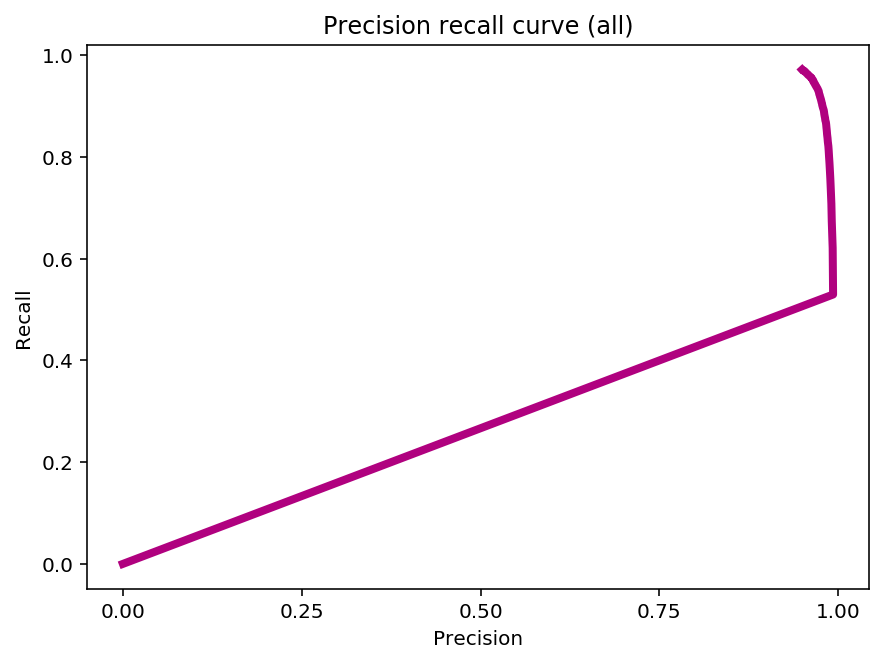

In [18]:
def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})
    
plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')

**Quiz Question: Using threshold = 0.98, how many false negatives do we get on the test_data? This is the number of false negatives (i.e the number of reviews to look at when not needed) that we have to deal with using this classifier.**

In [19]:
cmat = confusion_matrix(y_true=test_data['sentiment'],
                        y_pred=apply_threshold(probabilities, 0.98),
                        labels=model.classes_)    # use the same order of class as the LR model.
print (' target_label | predicted_label | count ')
print ('--------------+-----------------+-------')
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print ('{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j]))

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  5049
     -1       |        1        |   192
      1       |       -1        |  8241
      1       |        1        | 19854


### Evaluating specific search terms
So far, we looked at the number of false positives for the entire test set. In this section, let's select reviews using a specific search term and optimize the precision on these reviews only. After all, a manufacturer would be interested in tuning the false positive rate just for their products (the reviews they want to read) rather than that of the entire set of products on Amazon.

### Precision-Recall on all baby related items
From the test set, select all the reviews for all products with the word 'baby' in them. If you are using SFrame, generate a binary mask with apply() and index test_data with the mask. Save the selection to a new data frame named baby_reviews.

In [20]:
test_data['name'] = test_data['name'].astype('str')

In [21]:
baby_reviews = test_data[test_data['name'].apply(lambda x: 'baby' in x.lower())]

Now, let's predict the probability of classifying these reviews as positive. Make sure to convert the column review_clean of baby_reviews into a 2D array before computing class probability values. In scikit-learn, this task would be implemented as follows:

In [22]:
baby_matrix = vectorizer.transform(baby_reviews['review_clean'])
probabilities = model.predict_proba(baby_matrix)[:,1]

Let's plot the precision-recall curve for the baby_reviews dataset. We again use 100 equally spaced values between 0.5 and 1 for the threshold.

In [23]:
threshold_values = np.linspace(0.5, 1, num=100)

For each of the values of threshold, we first obtain class predictions for baby_reviews using that threshold. Then we compute the precision and recall scores for baby_reviews. Save the precision scores and recall scores to lists precision_all and recall_all, respectively.

Quiz Question: Among all the threshold values tried, what is the smallest threshold value that achieves a precision of 96.5% or better for the reviews of data in baby_reviews? Round your answer to 3 decimal places.

Quiz Question: Is this threshold value smaller or larger than the threshold used for the entire dataset to achieve the same specified precision of 96.5%?

In [24]:
precision_all = [precision_score(y_true=baby_reviews['sentiment'], y_pred=apply_threshold(probabilities, threshold))
                 for threshold in threshold_values ]

recall_all = [recall_score(y_true=baby_reviews['sentiment'], y_pred=apply_threshold(probabilities, threshold))
                 for threshold in threshold_values]

In [26]:
new_list =[]
for i in zip(threshold_values, precision_all):
    thre, preci = i
   
    if preci >= 0.965:
        new_list.append(thre) 
        
print (min(new_list))

0.7272727272727273


### Plot the precision-recall curve for baby_reviews only by running

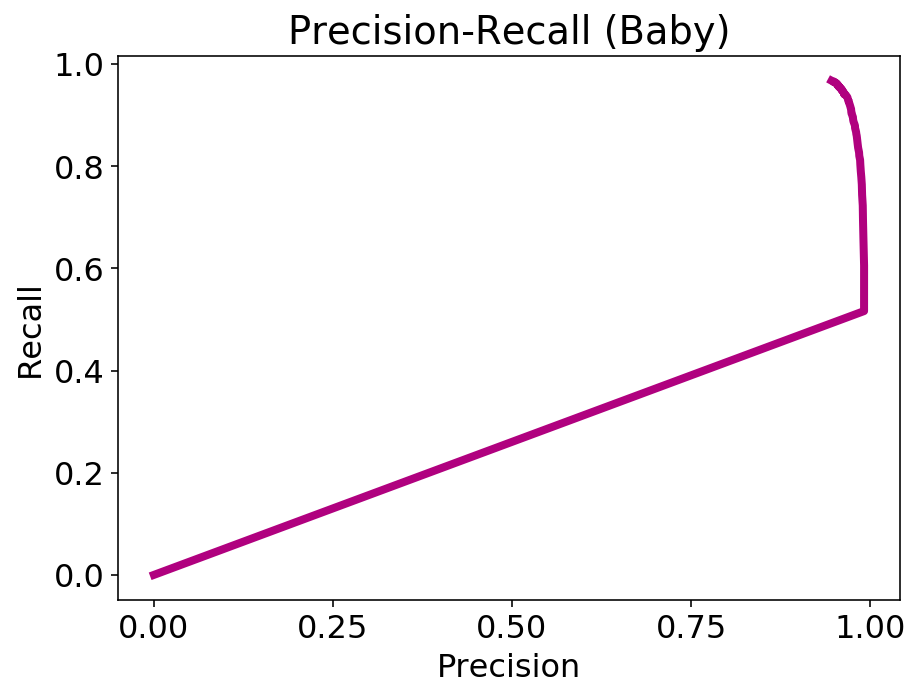

In [27]:
plot_pr_curve(precision_all, recall_all, "Precision-Recall (Baby)")